In [0]:
#@title importing { form-width: "2%" }
import os

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn
import torch

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from tqdm import tqdm_notebook as tqdm

from google.colab import drive, files

import tarfile


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")



In [0]:
#@title download dataset { form-width: "2%" }
import os
if not os.path.exists('Task02_Heart.tar'):
  !pip install dropbox
  import dropbox
  dbx = dropbox.Dropbox("UoR0mfv25MkAAAAAAAAHW1YVi-oWANipOhVmdvxR72tbK_YtqOHDEc1gpMtqNvXB")
  with open("Task02_Heart.tar", "wb") as f:
    metadata, res = dbx.files_download(path="/Task02_Heart.tar")
    f.write(res.content)
  import tarfile        
  tar = tarfile.open(name='/content/Task02_Heart.tar', mode='r')
  tar.extractall()
  tar.close()

if not 'imageSet' in locals():
  result={}
  imageSet=labelSet=np.empty((320, 320, 90, 1))
  import glob, os
  os.chdir("/content/Task02_Heart/imagesTr")
  for file in glob.glob("*.gz"):
      # print(file)
      result['image'] = nib.load('/content/Task02_Heart/imagesTr/'+file)      
      image2reference = result['image'].affine
      result['image'] = result['image'].get_data()[:, :, :, np.newaxis]
      x=result['image']
      x=x[:320, :320, :90, :1]
      imageSet=np.concatenate((imageSet, x), axis=3)
  imageSet=imageSet[:, :, :, 1:]
  imageSet = torch.from_numpy(imageSet).float()
  imageSet = imageSet.squeeze(0).permute(3, 2, 1, 0)
  imageSet = imageSet.unsqueeze(1)
  print('after crop', (imageSet).shape)

  os.chdir("/content/Task02_Heart/labelsTr")
  for file in glob.glob("*.gz"):
      # print(file)
      result['image'] = nib.load('/content/Task02_Heart/labelsTr/'+file)      
      image2reference = result['image'].affine
      result['image'] = result['image'].get_data()[:, :, :, np.newaxis]
      x=result['image']
      x=x[:320, :320, :90, :1]
      labelSet=np.concatenate((labelSet, x), axis=3)
  labelSet=labelSet[:, :, :, 1:]
  labelSet = torch.from_numpy(labelSet).float()
  labelSet = labelSet.squeeze(0).permute(3, 2, 1, 0)
  labelSet = labelSet.unsqueeze(1)
  print('after crop', (labelSet).shape)

     |████████████████████████████████| 645kB 2.6MB/s 
after crop torch.Size([20, 1, 90, 320, 320])
after crop torch.Size([20, 1, 90, 320, 320])


In [0]:
#@title grid sample withoul loop { form-width: "5%" }
# Create fake image
# image = torch.zeros(20, 1, 90, 320, 320)
# image = labelSet[0, :, :, :, :].unsqueeze(0)

image = imageSet
# Create grid
# out_size = 12
# x = torch.linspace(-1, 1, out_size).view(-1, 1).repeat(1, out_size)
# print('linspace', (x).shape)
# y = torch.linspace(-1, 1, out_size).repeat(out_size, 1)
# grid = torch.cat((x.unsqueeze(2), y.unsqueeze(2)), 2)
# print('cat', (grid).shape)
# grid.unsqueeze_(0)


theta=torch.tensor([[[.5, 0., 0., -0.1],
                     [0., .5, 0., 0.0],
                     [0., 0., .5, 0.]]]).repeat(20, 1, 1)


grid=F.affine_grid(theta, (20, 1, 24, 80, 80))

imageSetSampled = F.grid_sample(imageSet, grid)
labelSetSampled = F.grid_sample(labelSet, grid)

# import matplotlib.pyplot as plt
# # plt.imshow(image[0].permute(1, 2, 0).numpy())
# printyy=imageSetSampled[0].squeeze(0).permute(1, 2, 0).numpy()
# plt.imshow(printyy[:, :, 20],cmap='gray') 


In [0]:
#@title  Unet { form-width: "1%" }


# inputs = sample["image"] # ADDED inputs.Size([4, 1, 48, 96, 64])
# labels = sample["label"] # ADDED labels.Size([4, 1, 48, 96, 64])

class Net(nn.Module):
  def __init__(self, unet=True):
    super().__init__()
    # ♛♡♡♞♞♤★★★DECODER★★★♛♡♡♞♞♤
    # Initial Size [4, 1, 48, 96, 64]
    self.conv1to32 = nn.Sequential(nn.BatchNorm3d(1),
                                nn.Conv3d(1, 32, 3, padding=1), nn.ReLU(),
                                nn.BatchNorm3d(32),
                                nn.Conv3d(32, 32, 3, padding=1),nn.ReLU())
    # After Size [4, 32, 48, 96, 64]
    self.mp1 = nn.MaxPool3d(2, 2, return_indices=True)
    # After Size [4, 32, 24, 48, 32]
    self.conv32to64 = nn.Sequential(nn.BatchNorm3d(32),
                                nn.Conv3d(32, 64, 3, padding=1),nn.ReLU(),
                                nn.BatchNorm3d(64),
                                nn.Conv3d(64, 64, 3, padding=1),nn.ReLU())
    # After Size [4, 64, 24, 48, 32]
    self.mp2 = nn.MaxPool3d(2, 2, return_indices=True)
    # After Size [4, 64, 12, 24, 16]
    self.conv64to128 = nn.Sequential(nn.BatchNorm3d(64),
                                nn.Conv3d(64, 128, 3, padding=1), nn.ReLU(),
                                nn.BatchNorm3d(128),
                                nn.Conv3d(128, 128, 3, padding=1), nn.ReLU())
    # After Size [4, 128, 12, 24, 16]
    self.mp3 = nn.MaxPool3d(2, 2, return_indices=True)
    # After Size [4, 128, 6, 12, 8]

    # Center part   



    self.conv128to128 = nn.Sequential(nn.BatchNorm3d(128),
                                nn.Conv3d(128, 128, 3, padding=1), nn.ReLU(),
                                nn.BatchNorm3d(128),
                                nn.Conv3d(128, 128, 3, padding=1), nn.ReLU())
    # After Size [4, 128, 6, 12, 8]




    # ♛♡♡♞♞♤★★★ENCODER★★★♛♡♡♞♞♤


    self.mup1 = nn.MaxUnpool3d(2, 2)
    # After Size [4, 128, 12, 24, 16]
    self.conv128to64 = nn.Sequential(nn.BatchNorm3d(256),
                                nn.Conv3d(256, 128, 3, padding=1), nn.ReLU(),
                                nn.BatchNorm3d(128),
                                nn.Conv3d(128, 64, 3, padding=1), nn.ReLU())
    # After Size [4, 64, 12, 24,  16]
    self.mup2 = nn.MaxUnpool3d(2, 2)
    # After Size [4, 64, 24, 48, 32]
    self.conv64to32 = nn.Sequential(nn.BatchNorm3d(128),
                                nn.Conv3d(128, 64, 3, padding=1), nn.ReLU(),
                                nn.BatchNorm3d(64),
                                nn.Conv3d(64, 32, 3, padding=1), nn.ReLU())
    # After Size [4, 32, 24, 48, 32]
    self.mup3 = nn.MaxUnpool3d(2, 2)
    # After Size [4, 32, 48, 96, 64]
    self.conv32to1Sigm = nn.Sequential(nn.BatchNorm3d(64),
                                nn.Conv3d(64, 32, 3, padding=1), nn.ReLU(),
                                nn.BatchNorm3d(32),
                                nn.Conv3d(32, 1, 3, padding=1),
                                nn.Sigmoid())
    # After Size [4, 1, 48, 96, 64]

  def forward(self, inputs):
    # Initial Size [4, 1, 48, 96, 64]
    x = self.conv1to32(inputs)
    # After Size [4, 32, 48, 96, 64]
    cat32=x                   # concatinating    [4, 32, 48, 96, 64]
    x, idx1 = self.mp1(x)
    # After Size [4, 32, 24, 48, 32]
    x = self.conv32to64(x)
    # After Size [4, 64, 24, 48, 32]
    cat64=x                   # concatinating    [4, 64, 24, 48, 32]
    x, idx2 = self.mp2(x)
    # After Size [4, 64, 12, 24, 16]
    x = self.conv64to128(x)
    # After Size [4, 128, 12, 24, 16]
    cat128=x                   # concatinating   [4, 128, 12, 24, 16]
    x, idx3 = self.mp3(x)
    # After Size [4, 128, 6, 12, 8]



    x = self.conv128to128(x)
    # After Size [4, 128, 6, 12, 8]



    x = self.mup1(x, idx3)
    # After Size [4, 128, 12, 24, 16]
    x=torch.cat((x, cat128), 1) # concatinating   [4, 128, 12, 24, 16]
    # After Size [4, 256, 12, 24, 16]
    x = self.conv128to64(x)
    # After Size [4, 64, 12, 24,  16]
    x = self.mup2(x, idx2)
    # After Size [4, 64, 24, 48, 32]
    x=torch.cat((x, cat64), 1) # concatinating    [4, 64, 24, 48, 32]
    # After Size [4, 128, 24, 48, 32]
    x = self.conv64to32(x)
    # After Size [4, 32, 24, 48, 32]
    x = self.mup3(x, idx1)
    # After Size [4, 32, 48, 96, 64]
    x=torch.cat((x, cat32), 1) # concatinating    [4, 32, 48, 96, 64]
    # After Size [4, 64, 48, 96, 64]
    x = self.conv32to1Sigm(x)
    # After Size [4, 1, 48, 96, 64]

    
    return x
net = Net()

In [0]:
#@title Data loader { form-width: "5%" }

class MyTraningSet(Dataset):
    def __init__(self):
        self.images = imageSetSampled[:16]
        self.labels = labelSetSampled[:16]
        
    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        
        return {'images': x, 'labels': y}
    
    def __len__(self):
        return len(self.images)

TraningSet = MyTraningSet()
TraningLoader = DataLoader(TraningSet, batch_size=4, num_workers=2)

class MyValidateSet(Dataset):
    def __init__(self):
        self.images = imageSetSampled[16:]
        self.labels = labelSetSampled[16:]
        
    def __getitem__(self, index):
        x = self.images[index]
        y = self.labels[index]
        
        return {'images': x, 'labels': y}
    
    def __len__(self):
        return len(self.images)

ValidateSet = MyValidateSet()
ValidateLoader = DataLoader(ValidateSet, batch_size=4, num_workers=2)


# for batch in loader:
#     images = batch['images']
#     labels = batch['labels']
#     print(images.numel())




In [0]:
#@title Traning { form-width: "5%" }
n_epochs = 100 #originally 31

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose3d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)



# net.apply(init_weights)


criterionBCE = nn.BCELoss()

def criterionDICE (f_label, m_label):
  numerator = 2.0*torch.sum(f_label.view(-1) * m_label.view(-1))
  denominator = torch.sum(f_label.view(-1)) + torch.sum(m_label.view(-1))
  return -(numerator / denominator)


optimizer = torch.optim.Adam(net.parameters(), lr=0.0006)



progress = tqdm(range(n_epochs), desc='progress')

with torch.set_grad_enabled(True):
  for epoch in progress:
    sum_loss = 0

    for batch in TraningLoader:
        images = batch['images'].to(device)
        labels = batch['labels'].to(device)
        net.zero_grad()
        result=net(images)
        loss = criterionDICE(result, labels)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()

    print('dice score:',sum_loss/4)



dice score: -0.08012230414897203
dice score: -0.11867882683873177
dice score: -0.1416359543800354
dice score: -0.16493767127394676
dice score: -0.18426378816366196
dice score: -0.20925920829176903
dice score: -0.20585205033421516
dice score: -0.23432303220033646
dice score: -0.25074101239442825
dice score: -0.2724089100956917
dice score: -0.3003727197647095
dice score: -0.3339524492621422
dice score: -0.3343359902501106
dice score: -0.3485115244984627
dice score: -0.37967611849308014
dice score: -0.3677143454551697
dice score: -0.4294687956571579
dice score: -0.4857097789645195
dice score: -0.5273138880729675
dice score: -0.5783694386482239
dice score: -0.632514238357544
dice score: -0.6506122797727585
dice score: -0.6989577263593674
dice score: -0.7390918433666229
dice score: -0.776248574256897
dice score: -0.7892515063285828
dice score: -0.8218351155519485
dice score: -0.8400698602199554
dice score: -0.8466019630432129
dice score: -0.8645528554916382
dice score: -0.8746964335441589
d

dice score: tensor(-0.8430, device='cuda:0')


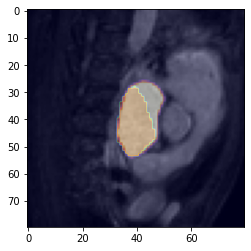

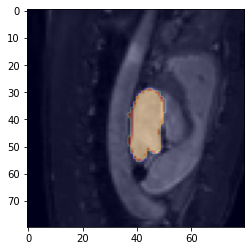

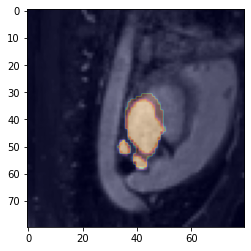

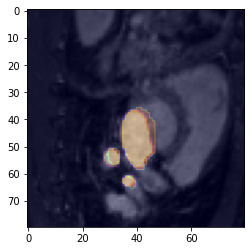

In [0]:

n_epochs= 1


with torch.set_grad_enabled(False):
  sum_loss = 0

  for batch in ValidateLoader:
      images = batch['images'].to(device)
      labels = batch['labels'].to(device)
      optimizer.zero_grad()
      result=net(images)
      loss = criterionDICE(result, labels)
      print('dice score:',loss)

      for i in range( images.size(0)):
        plt.figure()

        imagescpu=images[i, :, 18].cpu().squeeze(0)
        plt.imshow(imagescpu, cmap='gray') 

        labelscpu=labels[i, :, 18].cpu().squeeze(0)
        plt.imshow(labelscpu, cmap='inferno', alpha=0.4) 

        resultcpu=result[i, :, 18].cpu().squeeze(0)
        plt.imshow(resultcpu, cmap='jet', alpha=0.2) 



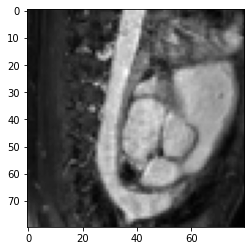

In [0]:
#@title video lables { form-width: "2%" }
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# TO MAKE DATA NUMPY FOR ANIMATION

experiment=imageSet
# experiment=experiment.permute(0,2,3,1)

fig = plt.figure()

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []

for i in range(24):
    # im = plt.imshow(experiment[0, 0,i,:,:], animated=True, cmap='gray')
    # ims.append([im])



    imagescpu=images[2, :, i].cpu().squeeze(0)
     
    labelscpu=labels[2, :, i].cpu().squeeze(0)
    # plt.imshow(labelscpu, cmap='inferno', alpha=0.4) 

    resultcpu=result[2, :, i].cpu().squeeze(0)
    # plt.imshow(resultcpu, cmap='jet', alpha=0.2) 

    combined=imagescpu

    im = plt.imshow(combined, animated=True, cmap='gray')

    
    ims.append([im])


ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)

# ani.save('dynamic_images.mp4')

# plt.show()

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
ani
